<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />
<br>
<font face="Calibri">

<font size="6"> <b> Flood Depth Estimation with Flood Extent Maps </b> </font> 

<font size="4"> <b> Part of NASA A.37 Project:</b> Integrating SAR Data for Improved Resilience and Response to Weather-Related Disasters   <br>
<font size="4"> <b> PI:</b>Franz J. Meyer <br>
<font size="3"> Version 0.1.12 - 2022/08/01 <br>
<b>Change Log:</b> See bottom of the notebook.<br>
    
<br>
<font size="4"> <b> Batuhan Osmanoglu, MinJeong Jo; NASA Goddard Space Fligth Center </b> <br>
</font>
    
<font size="3"> This notebook provides the processor to generate Water Depth map named WD30 using the Hydro30 water mask which is the flood extent map product. This processor also works for any flood extent map generated from any source of satellite imagery.

<hr>

# Importing Relevant Python Packages

In [1]:
#Setup Environment
import os
import urllib
import numpy as np
from osgeo import gdal
from osgeo import osr
# import json
# import glob
# import scipy # in first try, had scipy error
from scipy import ndimage
# from scipy import interpolate
from scipy import optimize
from scipy import stats
# from importlib import reload
# from skimage import morphology
import pylab as pl
import pprint
# import concurrent.futures as cf
from IPython.core.debugger import set_trace
#The two lines below are for visually browsing and selecting the DEM. 
import ipywidgets as ui
from IPython.display import display
import math

import warnings
import astropy
import astropy.convolution
# import pykrige
# import pysheds
# from pysheds.grid import Grid
# from affine import Affine
import rasterio
import pyproj
# from zipfile import ZipFile

#Download packages
codes_folder='/home/jovyan/codes'
project_dir=os.getcwd()
try:
    os.chdir(codes_folder)
except:
    os.mkdir(codes_folder)
    os.chdir(codes_folder)

if not os.path.exists(codes_folder+'/adore-doris/'):
  !git clone https://github.com/bosmanoglu/adore-doris.git
os.sys.path.append(codes_folder+'/adore-doris/lib/python')
os.sys.path.append(codes_folder)
os.chdir(project_dir) #Go back to project folder

#import modules after downloads
import gis
# import surface_from_grad as sfg
# import deramp as surface
# import invdisttree
from tqdm.notebook import tqdm

#for validation:
# import geopandas 
# from sklearn import metrics  

%matplotlib inline

# Define Common Parameters

<font face="Calibri" size="3">This section allows you to customize how flood depth estimation is performed. <b>The main parameters that users might want to change are</b>:
    
<ul>
 <li>
<b>Input File Naming Scheme (pattern):</b> This is only relevant if you are interested in mosaicking large areas. This gives you the option of either picking initial flood mapping information created in Lab 2 (naming scheme <i>*_water_mask_combined.tiff</i>) or final post-processed flood mapping information (naming scheme <i>*_fcWM.tiff</i>) for flood depth calculation.
    </li><br>
 
  <li><b>Estimator:</b> The Iterative estimation approach is adopted by the HydroSAR team for the current version of the program: 
    <li style="margin-left:2em"><b>Iterative:</b> Basin hopping optimization method to match flooded areas to flood depth estimates given the HAND layer. From our current experience, this is the most accurate, but also the most time consuming approach.</li>
    </ul>

</ul>
</font>

In [2]:
#parameters setup
version="0.1.12"
water_classes = [1,2,3,4,5] # 1 has to be a water class, 0 is no water Others are optional.
pattern="*_fcWM*.tif" #"filter_*_amp_Classified.tif"
show_plots=True #turn this off for debugging with IPDB
estimator = "iterative-basinhopping" #"iterative-brute" #"ensemble-basinhopping" 
iterative_bounds=[0,6] #only used for iterative
water_level_sigma=3 #use 3*std to estimate max. water height (water level) for each object. Used for numpy, nmad,logstat
output_prefix='' # Output file is created in the same folder as flood extent. A prefix can be added to the filename.
niter=1000 #for basinhopping
niter_success=100 #for basinhopping
minimization_metric='fmi' # 'threat_score' or 'fmi' #Reference: https://en.wikipedia.org/wiki/Confusion_matrix
#ths=30 #Threshold for extracting the pre-existing surface water area in percent. 
ths='auto' #5 #Threshold for extracting the pre-existing surface water area in percent.
if show_plots:
    %matplotlib notebook

# Define Convenience Functions

In [3]:
# Define convenience functions
def bounding_box_inside_bounding_box(small, big):
    s0=np.array([p[0] for p in small])
    s1=np.array([p[1] for p in small])
    b0=np.array([p[0] for p in big])
    b1=np.array([p[1] for p in big])
    inside=True
    if s0.min()<b0.min():
        inside=False
    if s0.max()>b0.max():
        inside=False
    if s1.min()<b1.min():
        inside=False
    if s1.max()>b1.max():
        inside=False
    return inside

def getGeoTransform(filename):
    warnings.warn("getGeoTransform will be deprecated in the future. Please use read_data instead.", PendingDeprecationWarning)
    return get_geotransform(filename)

def get_geotransform(filename):
    '''
    [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]=getGeoTransform('/path/to/file')
    '''
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    ds = gdal.Open(filename)
    return ds.GetGeoTransform()

def build_vrt(filename, input_file_list):
    vrt_options = gdal.BuildVRTOptions(resampleAlg='near', resolution='highest', separate=False, targetAlignedPixels=True)
    gdal.BuildVRT(filename,input_file_list,options=vrt_options)

def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

def gdal_get_projection(filename, out_format='proj4'):
    """
    epsg_string=get_epsg(filename, out_format='proj4')
    """
    try:
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      srs=gdal.osr.SpatialReference()
      srs.ImportFromWkt(ds.GetProjectionRef())
    except: #I am not sure if this is working for datasets without a layer. The first try block should work mostly.
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      ly=ds.GetLayer()
      if ly is None:
        print(f"Can not read projection from file:{filename}")
        return None
      else:
        srs=ly.GetSpatialRef()
    if out_format.lower()=='proj4':
      return srs.ExportToProj4()
    elif out_format.lower()=='wkt':
      return srs.ExportToWkt()
    elif out_format.lower()=='epsg':
      crs=pyproj.crs.CRS.from_proj4(srs.ExportToProj4())
      return crs.to_epsg()


def get_size(filename):
    """(width, height) = get_size(filename)
    """
    ds = gdal.Open(filename)
    width = ds.RasterXSize
    height = ds.RasterYSize
    ds=None
    return (width, height)
def get_proj4(filename):
    f=rasterio.open(filename)
    return pyproj.Proj(f.crs, preserve_units=True)  #used in pysheds
def clip_gT(gT, xmin, xmax, ymin, ymax, method='image'):
    '''calculate new geotransform for a clipped raster either using pixels or projected coordinates.
    clipped_gT=clip_gT(gT, xmin, xmax, ymin, ymax, method='image')
    method: 'image' | 'coord'
    '''
    if method == 'image':
      y,x=xy2coord(ymin, xmin, gT); #top left, reference, coordinate
    if method == 'coord':
      #find nearest pixel
      yi, xi = coord2xy(ymin, xmin, gT)
      #get pixel coordinate
      y,x=xy2coord(yi, xi, gT)
    gTc=list(gT)
    gTc[0]=y
    gTc[3]=x
    return tuple(gTc)
def xy2coord(x,y,gT):
    '''
    lon,lat=xy2coord(x,y,geoTransform)
    projects pixel index to position based on geotransform.
    '''
    coord_x=gT[0] + x*gT[1] + y*gT[2]
    coord_y=gT[3] + x*gT[4] + y*gT[5]
    return coord_x, coord_y

def coord2xy(x,y,gT):
    '''
    x,y = coord2xy(lon, lat, geoTransform)
    calculates pixel index closest to the lon, lat.
    '''
    #ref: https://gis.stackexchange.com/questions/221292/retrieve-pixel-value-with-geographic-coordinate-as-input-with-gdal/221430
    xOrigin = gT[0]
    yOrigin = gT[3]
    pixelWidth = gT[1]
    pixelHeight = -gT[5]

    col = np.array((x - xOrigin) / pixelWidth).astype(int)
    row = np.array((yOrigin - y) / pixelHeight).astype(int)

    return row,col
def fitSurface(x,y,z,X,Y):
    p0=[0,0.1,0.1]
    fitfunc = lambda p, x, y: p[0]+p[1]*x+p[2]*y
    errfunc = lambda p, x, y, z: abs(fitfunc(p,x,y) - z)
    planefit, success=optimize.leastsq(errfunc, p0, args=(x,y,z))
    return fitfunc(planefit, X,Y)    
def nonan(A, rows=False):
    if rows:
        return A[np.isnan(A).sum(1)==0];
    else:
        return A[~np.isnan(A)];

def get_wesn(filename, t_srs=None):
    bb=bounding_box(filename, t_srs=t_srs)
    w=np.inf
    e=-np.inf
    n=-np.inf
    s=np.inf
    for p in bb:
        if p[0]<w:
            w=p[0]
        if p[0]>e:
            e=p[0]
        if p[1]<s:
            s=p[1]
        if p[1]>n:
            n=p[1]
    return [w,e,s,n]
def bounding_box(filename, t_srs=None):
    """
    ((lon1,lat1), (lon2,lat2), (lon3,lat3), (lon4,lat4))=bounding_box('/path/to/file', t_srs=None) #returns x,y in native coordinate system
    ((lon1,lat1), (lon2,lat2), (lon3,lat3), (lon4,lat4))=bounding_box('/path/to/file', t_srs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    """
    gT=getGeoTransform(filename)
    width, height=get_size(filename)
    pts=(xy2coord(0,0,gT), xy2coord(width,0,gT), xy2coord(width, height,gT), xy2coord(0, height,gT))
    if t_srs is None:
        return pts
    else:
        pts_tsrs=[]
        s_srs=gdal_get_projection(filename, out_format='proj4')
        for p in pts:
            pts_tsrs.append(transform_point(p[0], p[1], 0, s_srs=s_srs, t_srs=t_srs))
            
    return tuple(pts_tsrs)   

def transform_point(x,y,z,s_srs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', t_srs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'):
    '''
    transform_point(x,y,z,s_srs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', t_srs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    
    Known Bugs: gdal transform may fail if a proj4 string can not be found for the EPSG or WKT formats. 
    '''    
    srs_cs=osr.SpatialReference()    
    if "EPSG" == s_srs[0:4]:    
      srs_cs.ImportFromEPSG(int(s_srs.split(':')[1]));
    elif "GEOCCS" == s_srs[0:6]:
      srs_cs.ImportFromWkt(s_srs);
    else:
      srs_cs.ImportFromProj4(s_srs);

    trs_cs=osr.SpatialReference()    
    if "EPSG" == t_srs[0:4]:    
      trs_cs.ImportFromEPSG(int(t_srs.split(':')[1]));
    elif "GEOCCS" == t_srs[0:6]:
      trs_cs.ImportFromWkt(t_srs);
    else:
      trs_cs.ImportFromProj4(t_srs);
    if int(gdal.VersionInfo())>2999999: #3010300
        #https://gdal.org/tutorials/osr_api_tut.html#crs-and-axis-order
        # https://github.com/OSGeo/gdal/blob/master/gdal/MIGRATION_GUIDE.TXT
        srs_cs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
        trs_cs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    transform = osr.CoordinateTransformation(srs_cs,trs_cs) 

    if numel(x)>1:
      return [  transformPoint(x[k], y[k], z[k]) for k in range(numel(x))]
    else:
      try:
        return transform.TransformPoint((x,y,z));
      except: 
        return transform.TransformPoint(x,y,z)

def get_waterbody(filename, ths, watermask=None):

    corners=bounding_box(filename)

    epsg=gdal_get_projection(filename, out_format='epsg')
    if epsg=="4326":         
        corners=bounding_box(filename)
    else:
        srs=gdal_get_projection(filename, out_format='proj4')
        corners=bounding_box(filename, t_srs="EPSG:4326")
    west= corners[0][0]
    east= corners[1][0]
    south= corners[2][1]
    north= corners[0][1]    
        

    cwd = os.getcwd()
    sw_path = f"{cwd}/S_WATER"
    if not os.path.exists(sw_path):
        os.mkdir(sw_path)

    lon = np.floor(west/10)
    lon=int(abs(lon*10))
    lat = np.ceil(north/10)
    lat=int(abs(lat*10))

    if (west<0 and north<0):
        urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}W_{lat}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}W_{lat}S.tif")
        if (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon-10}W_{lat}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon-10}W_{lat}S.tif")
        if (np.floor(north/10) != np.floor(south/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}W_{lat+10}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}W_{lat+10}S.tif")
        if (np.floor(north/10) != np.floor(south/10)) and (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon-10}W_{lat+10}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon-10}W_{lat+10}S.tif")
        print(f"lon: {lon}-{lon-10}W, lat: {lat}-{lat+10}S ")

    elif (west<0 and north>=0):
        urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}W_{lat}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}W_{lat}N.tif")
        if (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon-10}W_{lat}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon-10}W_{lat}N.tif")
        if (np.floor(north/10) != np.floor(south/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}W_{lat-10}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}W_{lat-10}N.tif")
        if (np.floor(north/10) != np.floor(south/10)) and (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon-10}W_{lat-10}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon-10}W_{lat-10}N.tif")
        print(f"lon: {lon}-{lon-10}W, lat: {lat}-{lat-10}N ")


    elif (west>=0 and north<0):
        urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}E_{lat}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}E_{lat}S.tif")
        if (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon+10}E_{lat}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon+10}E_{lat}S.tif")
        if (np.floor(north/10) != np.floor(south/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}E_{lat+10}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}E_{lat+10}S.tif")
        if (np.floor(north/10) != np.floor(south/10)) and (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon+10}E_{lat+10}Sv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon+10}E_{lat+10}S.tif")
        print(f"lon: {lon}-{lon+10}E, lat: {lat}-{lat+10}S ")

    else:
        urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}E_{lat}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}E_{lat}N.tif")
        if (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon+10}E_{lat}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon+10}E_{lat}N.tif")
        if (np.floor(north/10) != np.floor(south/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon}E_{lat-10}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon}E_{lat-10}N.tif")
        if (np.floor(north/10) != np.floor(south/10)) and (np.floor(west/10) != np.floor(east/10)):
            urllib.request.urlretrieve(f"https://storage.googleapis.com/global-surface-water/downloads2019v2/occurrence/occurrence_{lon+10}E_{lat-10}Nv1_1_2019.tif", f"{cwd}/S_WATER/surface_water_{lon+10}E_{lat-10}N.tif")
        print(f"lon: {lon}-{lon+10}E, lat: {lat}-{lat-10}N ")

    # Building the virtual raster for Change Detection product(tiff)
    product_wpath = f"{cwd}/S_WATER/surface_water*.tif"
    #wildcard_path = f"{cwd}/change_VV_20170818T122205_20170830T122203.tif"
    print(product_wpath)
    os.chdir(cwd)

    get_ipython().system('gdalbuildvrt surface_water_map.vrt $product_wpath')

    #Clipping/Resampling Surface Water Map for AOI
    dim =get_size(filename)
    if epsg=="4326":
        cmd_resamp=f"gdalwarp -overwrite -te {west} {south} {east} {north} -ts {dim[0]} {dim[1]} -r nearest {cwd}/surface_water_map.vrt {cwd}/surface_water_map_clip.tif"
    else:   
        corners=bounding_box(filename) # we now need corners in the non EPSG:4326 format.  
        west= corners[0][0]
        east= corners[1][0]
        south= corners[2][1]
        north= corners[0][1]            
        cmd_resamp=f"gdalwarp -overwrite -t_srs '{srs}' -te {west} {south} {east} {north} -ts {dim[0]} {dim[1]} -r nearest {cwd}/surface_water_map.vrt {cwd}/surface_water_map_clip.tif"        
    print(cmd_resamp)
    os.system(cmd_resamp)

    #load resampled water map
    wimage_file =f"{cwd}/surface_water_map_clip.tif"
    #water_map = gdal.Open(wimage_file)
    #print(f"X-dimension: {water_map.RasterXSize} Y-dimension: {water_map.RasterYSize}")
    
    swater_map =gis.readData(wimage_file)
    if ths=='auto':
        mean_occurance=swater_map[watermask].mean()
        hist, bin_edges = np.histogram(swater_map[watermask], density=True, bins=100)        
        reverse_cdf=np.cumsum(np.flipud(hist))*(bin_edges[1] - bin_edges[0]) # reverse CDF because we are doing swater_map > ths. We are taking everything bigger so have to reverse the CDF. 
        potential_thresholds=np.flipud(bin_edges)
        #find 95% point of the reverse_CDF        
        ths_orig=potential_thresholds[np.searchsorted(np.array(reverse_cdf), 0.95)] # Select the smallest percentage that gives us 95% overlap with Hydro30 and threshold. 
        ths=round(ths_orig)+1
        print(f'Perennial water threshold automatically set to: {ths}')            
    wmask=swater_map>ths   #higher than 30% possibility (present water)
    print(ths)    
    return wmask

def numel(x):
    if isinstance(x, int):
      return 1
    elif isinstance(x, np.double):
      return 1
    elif isinstance(x, float):
      return 1
    elif isinstance(x, str):
      return 1
    elif isinstance(x, list) or isinstance(x, tuple):
      return len(x)
    elif isinstance(x, np.ndarray):
      return x.size
    else: 
      print('Unknown type {}.'.format(type(x)))
      return None

def yesno(yes_no_question="[y/n]"):
    while True:
        # raw_input returns the empty string for "enter"
        yes = {'yes','y', 'ye'}
        no = {'no','n'}

        choice = input(yes_no_question+"[y/n]").lower()
        if choice in yes:
            return True
        elif choice in no:
            return False
        else:
            print("Please respond with 'yes' or 'no'")
def fill_nan(arr):
    """
    filled_arr=fill_nan(arr)
    Fills Not-a-number values in arr using astropy. 
    """    
    kernel = astropy.convolution.Gaussian2DKernel(x_stddev=3) #kernel x_size=8*stddev
    arr_type=arr.dtype          
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while np.any(np.isnan(arr)):
            arr = astropy.convolution.interpolate_replace_nans(arr.astype(float), kernel, convolve=astropy.convolution.convolve)
    return arr.astype(arr_type) 

def logstat(data, func=np.nanstd):
    """ stat=logstat(data, func=np.nanstd)
       calculates the statistic after taking the log and returns the statistic in linear scale.
       INF values inside the data array are set to nan. 
       The func has to be able to handle nan values. 
    """
    ld=np.log(data)
    ld[np.isinf(ld)]=np.nan #requires func to handle nan-data.
    st=func(ld)
    return np.exp(st)

def iterative(hand, extent, init_depth, water_levels=range(max(iterative_bounds)), method='basinhopping', niter=1000,niter_success=100, minimization_metric='threat_score'): 
    '''----------
    Parameters
    - hand(array): clipped hand map for a slice (a single water body) 
    - extent(array):clipped water mask for a slice (a single water body)
    - water_levels: a series of numbers within a given range. iterative_bounds=[0,15] at the parameter setup
    ----------    
    Returns
    - best_water_level(float): water height  
    ----------'''
    
    def _goal_ts(w): 
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-TP/(TP+FP+FN) #threat score #we will minimize goal func, hence 1-threat_score.

    def _goal_acc(w):
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-(TP+TN)/(TP+TN+FP+FN) #accuracy #we will minimize goal func, hence 1-accuracy.
    def _goal_sensitivity(w):#providides very high flood depth ~14m
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-(TP)/(TP+FN) #sensitivity #we will minimize goal func, hence 1-sensitivity.    
    def _goal_specificity(w): #providides very low flood depth <1m
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-(TN)/(TN+FP) #sensitivity #we will minimize goal func, hence 1-sensitivity.  
    def _goal_precision(w): #providides very low flood depth ~1m
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-(TP)/(TP+FP) #precision #we will minimize goal func, hence 1-precision.     
    def _goal_f1(w): #providides very low flood depth ~1.4m
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-(2*TP)/(2*TP+FP+FN) #precision #we will minimize goal func, hence 1-precision. 
    def _goal_bal_acc(w): # balanced accuracy
        set_trace()
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        TPR=TP/(TP+FN)
        TNR=TN/(TN+FP)
        return 1-0.5*(TPR+TNR) #balanced accuracy #we will minimize goal func, hence 1-balanced accuracy. 
    
    def _goal_fmi(w): #results in ~5m depth.
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-np.sqrt((TP/(TP+FP))*(TP/(TP+FN)))
    def _goal_markedness(w):#results in ~5m depth.
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative 
        PPV=TP/(TP+FP)
        NPV=TN/(TN+FN)
        return 1-(PPV+NPV-1) 
    
    def return_func(metric):
        if metric.lower()=='threat_score':
            return _goal_ts
        elif metric.lower()=='fmi':
            return _goal_fmi
        else:
            print('Using default minimization function: _goal_ts')
            return _goal_ts
    
    class MyBounds(object):
        def __init__(self, xmax=[max(water_levels)], xmin=[min(water_levels)] ):
            self.xmax = np.array(xmax)
            self.xmin = np.array(xmin)
        def __call__(self, **kwargs):
            x = kwargs["x_new"]
            tmax = bool(np.all(x <= self.xmax))
            tmin = bool(np.all(x >= self.xmin))
            return tmax and tmin
    mybounds = MyBounds()
    x0=[np.mean(water_levels)]  # block
    #x0=init_depth # initial depth estimate calculated from nmad estimator, modified in 2022-04-28
    if method.lower()=='basinhopping':
        opt_res=optimize.basinhopping(return_func(minimization_metric), x0,niter=niter, niter_success=niter_success, accept_test=mybounds, stepsize=3)
        if opt_res.message[0]=='success condition satisfied' or opt_res.message[0]=='requested number of basinhopping iterations completed successfully':
            best_water_level=opt_res.x[0]
        else:        
            best_water_level=np.inf # set to inf to mark unstable solution.    
    elif method.lower()=='scalar':
        opt_res = optimize.minimize_scalar(return_func(minimization_metric), bounds=[min(water_levels), max(water_levels)], method='bounded') 
        if opt_res.message=='Solution found.':
            best_water_level=opt_res.x
        else:
            best_water_level=np.inf
    elif method.lower()=='brute':
        ranges=((min(water_levels), max(water_levels)),)
        Ns=max(water_levels)-min(water_levels)
        opt_res = optimize.brute(return_func(minimization_metric), ranges, Ns=Ns, finish=None) 
        best_water_level=opt_res    
    elif method.lower()=='differential_evolution':
        opt_res = optimize.differential_evolution(return_func(minimization_metric), (tuple(water_levels),)) 
        if opt_res.message=='Optimization terminated successfully.':
            best_water_level=opt_res.x[0]
        else:
            best_water_level=np.inf 
    elif method.lower()=='shgo':
        opt_res = optimize.shgo(return_func(minimization_metric), (tuple(water_levels),)) 
        if opt_res.message=='Optimization terminated successfully.':
            best_water_level=opt_res.x[0]
        else:
            best_water_level=np.inf             
    elif method.lower()=='dual_annealing':
        opt_res = optimize.dual_annealing(return_func(minimization_metric), bounds=[(min(water_levels), max(water_levels))]) 
        if opt_res.message[0]=='Maximum number of iteration reached':
            best_water_level=opt_res.x[0]
        else:
            best_water_level=np.inf       
    return best_water_level

def debug_confusion_matrix(hand,extent):
    wl=[]
    TP=[]
    TN=[]
    FP=[]
    FN=[]
    for w in range(16):
        iterative_flood_extent=hand<w # w=water level
        wl.append(w)
        TP.append(np.nansum(np.logical_and(iterative_flood_extent==1, extent==1))) #true positive
        TN.append(np.nansum(np.logical_and(iterative_flood_extent==0, extent==0))) # True negative
        FP.append(np.nansum(np.logical_and(iterative_flood_extent==1, extent==0))) # False positive
        FN.append(np.nansum(np.logical_and(iterative_flood_extent==0, extent==1))) # False negative       
    print(wl)
    print(TP)
    print(TN)
    print(FP)
    print(FN)

def ensemble(hand, extent, water_levels=range(max(iterative_bounds)), method='basinhopping', niter=1000,niter_success=100, minimization_metric='threat_score'): 
    '''----------
    Parameters
    - hand(array): clipped hand map for a slice (a single water body) 
    - extent(array):clipped water mask for a slice (a single water body)
    - water_levels: a series of numbers within a given range. iterative_bounds=[0,15] at the parameter setup
    ----------    
    Returns
    - best_water_level(float): water height  
    ----------'''
    
    def _goal_ts(w):
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-TP/(TP+FP+FN) #threat score #we will minimize goal func, hence 1-threat_score.
    def _goal_fmi(w): #results in ~5m depth.
        iterative_flood_extent=hand<w # w=water level
        TP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==1)) #true positive
        TN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==0)) # True negative
        FP=np.nansum(np.logical_and(iterative_flood_extent==1, extent==0)) # False positive
        FN=np.nansum(np.logical_and(iterative_flood_extent==0, extent==1)) # False negative
        return 1-np.sqrt((TP/(TP+FP))*(TP/(TP+FN)))    
    def return_func(metric):
        if metric.lower()=='threat_score':
            return _goal_ts
        elif metric.lower()=='fmi':
            return _goal_fmi
        else:
            print('Using default minimization function: _goal_ts')
            return _goal_ts
    
    class MyBounds(object):
        def __init__(self, xmax=[max(water_levels)], xmin=[min(water_levels)] ):
            self.xmax = np.array(xmax)
            self.xmin = np.array(xmin)
        def __call__(self, **kwargs):
            x = kwargs["x_new"]
            tmax = bool(np.all(x <= self.xmax))
            tmin = bool(np.all(x >= self.xmin))
            return tmax and tmin
    mybounds = MyBounds()
    #x0=[np.mean(water_levels)]  # block
    temp_wl = np.zeros(math.floor(max(iterative_bounds)/2))# modified by MJ 06/07/2022
    #m=0
    for m,x0 in enumerate(range(1, max(iterative_bounds),2)):
        #x0=i        
        if method.lower()=='basinhopping':
            opt_res=optimize.basinhopping(return_func(minimization_metric), x0,niter=niter, niter_success=niter_success, accept_test=mybounds, stepsize=3)
            #opt_res=optimize.basinhopping(_goal_ts, x0,niter=100, niter_success=10, accept_test=mybounds, stepsize=0.5) #RMSE=4.50
            #opt_res=optimize.basinhopping(_goal_ts, x0,niter=200, niter_success=10, accept_test=mybounds, stepsize=0.5) #RMSE=3.78
            #opt_res=optimize.basinhopping(_goal_ts, x0,niter=400, niter_success=10, accept_test=mybounds, stepsize=0.5) #RMSE=4.09            
            #opt_res=optimize.basinhopping(_goal_ts, x0,niter=1000, niter_success=10, accept_test=mybounds, stepsize=0.5) # RMSE=4.10
            #opt_res=optimize.basinhopping(_goal_ts, x0,niter=400, niter_success=50, accept_test=mybounds, stepsize=0.5) # RMSE=4.10
            if opt_res.message[0]=='success condition satisfied' or opt_res.message[0]=='requested number of basinhopping iterations completed successfully':
                temp_wl[m]=opt_res.x[0]
            else:        
                temp_wl[m]=np.inf # set to inf to mark unstable solution.    
        elif method.lower()=='scalar':
            opt_res = optimize.minimize_scalar(return_func(minimization_metric), bounds=[min(water_levels), max(water_levels)], method='bounded') 
            if opt_res.message=='Solution found.':
                temp_wl[m]=opt_res.x
            else:
                temp_wl[m]=np.inf
        elif method.lower()=='brute':
            ranges=((min(water_levels), max(water_levels)),)
            Ns=max(water_levels)-min(water_levels)
            opt_res = optimize.brute(return_func(minimization_metric), ranges, Ns=Ns, finish=None) 
            temp_wl[m]=opt_res    
        elif method.lower()=='differential_evolution':
            opt_res = optimize.differential_evolution(return_func(minimization_metric), (tuple(water_levels),), x0=x0) 
            if opt_res.message=='Optimization terminated successfully.':
                temp_wl[m]=opt_res.x[0]
            else:
                temp_wl[m]=np.inf 
        elif method.lower()=='shgo':
            opt_res = optimize.shgo(return_func(minimization_metric), (tuple(water_levels),)) 
            if opt_res.message=='Optimization terminated successfully.':
                temp_wl[m]=opt_res.x[0]
            else:
                temp_wl[m]=np.inf             
        elif method.lower()=='dual_annealing':
            opt_res = optimize.dual_annealing(return_func(minimization_metric), bounds=[(min(water_levels), max(water_levels))], x0=[x0]) 
            if opt_res.message[0]=='Maximum number of iteration reached':
                temp_wl[m]=opt_res.x[0]
            else:
                temp_wl[m]=np.inf       
    best_water_level_opt = np.nanmean(temp_wl)       
    #return best_water_level
    return best_water_level_opt, temp_wl

In [4]:
class PathSelector():
    """
    Displays a file selection tree. Any file can be selected. 
    Selected path can be obtained by: PathSelector.accord.get_title(0)
    """
    def __init__(self,start_dir,select_file=True):
        self.file        = None 
        self.select_file = select_file
        self.cwd         = start_dir
        self.select      = ui.SelectMultiple(options=['init'],value=(),rows=10,description='') 
        self.accord      = ui.Accordion(children=[self.select]) 

        self.accord.selected_index = None # Start closed (showing path only)
        self.refresh(self.cwd)
        self.select.observe(self.on_update,'value')

    def on_update(self,change):
        if len(change['new']) > 0:
            self.refresh(change['new'][0])

    def refresh(self,item):
        path = os.path.abspath(os.path.join(self.cwd,item))

        if os.path.isfile(path):
            if self.select_file:
                self.accord.set_title(0,path)  
                self.file = path
                self.accord.selected_index = None
            else:
                self.select.value = ()

        else: # os.path.isdir(path)
            self.file = None 
            self.cwd  = path

            # Build list of files and dirs
            keys = ['[..]']; 
            for item in os.listdir(path):
                if item[0] == '.':
                    continue
                elif os.path.isdir(os.path.join(path,item)):
                    keys.append('['+item+']'); 
                else:
                    keys.append(item); 

            # Sort and create list of output values
            keys.sort(key=str.lower)
            vals = []
            for k in keys:
                if k[0] == '[':
                    vals.append(k[1:-1]) # strip off brackets
                else:
                    vals.append(k)

            # Update widget
            self.accord.set_title(0,path)  
            self.select.options = list(zip(keys,vals)) 
            with self.select.hold_trait_notifications():
                self.select.value = ()

# Prepare Data Set for HAND Calculation

<br>
<font face="Calibri" size="4"><b>Enter the path to the directory holding your tiffs:</b> <br>Here we ask you if you want to calculate flood depth across a mosaic or for a single file. In case of mosaicking multiple files, the final water mask's name will be the same with the work directory name. </font>

In [5]:
#Here we ask if we are processing a spatial mosaic or a single file. In case of mosaicking multile files, the final water mask's name will be the same with the work directory name 
if yesno("Would you like to mosaic multiple files (e.g. large area coverage from multiple scenes)?"):
    print(f"Choose one of the water extent files inside the folder. All files with matching the following will be processed: {pattern}")
    file_folder_func=lambda x: os.path.dirname(x)
    single_file=False
else:    
    print("Choose your GDAL compatible Classified water extent file using the file browser below:")
    file_folder_func=lambda x: x
    single_file=True
f = PathSelector('.')
display(f.accord)

Would you like to mosaic multiple files (e.g. large area coverage from multiple scenes)?[y/n] n


Choose your GDAL compatible Classified water extent file using the file browser below:


Accordion(children=(SelectMultiple(options=(('[..]', '..'), ('[FD30_Final_test]', 'FD30_Final_test'), ('[noteb…

In [6]:
#Check if folder or file
tiff_path=file_folder_func(f.accord.get_title(0))
if not single_file:
    #merge all tifs
    cwd = os.getcwd()
    tiffs_path = f'{tiff_path}/*_fcWM*.tif'
    #tiffs=glob.glob(f"{tiff_path}/{pattern}")
    #print("Processing the following files:")
    pprint.pprint(tiffs_path)
    #combined_vrt=os.path.join(tiff_path, os.path.basename(tiff_path)+'.vrt')
    get_ipython().system('gdalbuildvrt $tiff_path/water_mask_merged.vrt $tiffs_path')
    combined_tif=os.path.join(tiff_path, os.path.basename(tiff_path)+'_merged_water_mask.tif')
    #build_vrt(combined_vrt, tiffs)
    #translate vrt to tif. There is a problem warping with the vrt.
    cmd_translate=f"gdal_translate -of GTiff {tiff_path}/water_mask_merged.vrt {combined_tif}"
    print(cmd_translate)
    exitcode=os.WEXITSTATUS(os.system(cmd_translate))
    if exitcode != 0:
        print("Error in creating a mosaic from selected files\n")
        print(f"\nCommand failed:\n {cmd_translate}")
        assert exitcode == 0
    tiff_path=combined_tif
else:
    pass # do nothing. 

<br>
<font face="Calibri" size="4"><b>Reproject tiffs from UTM to EPSG 4326:</b> </font>

In [7]:
print("Choose your GDAL compatible precalculated HAND file using the file browser below:")
f = PathSelector('.')
display(f.accord)        

Choose your GDAL compatible precalculated HAND file using the file browser below:


Accordion(children=(SelectMultiple(options=(('[..]', '..'), ('[FD30_Final_test]', 'FD30_Final_test'), ('[noteb…

In [8]:
#checking current coordinate reference system
tiff_dir = os.path.dirname(tiff_path)
info = (gdal.Info(tiff_path, options = ['-json']))
info=info['coordinateSystem']['wkt']
epsg = info.split('ID')[-1].split(',')[1].replace(']','')
print(f"EPSG code for Water Extent: {epsg}")

hand_dem=f.accord.get_title(0)
info_hand = (gdal.Info(hand_dem, options = ['-json']))
info_hand=info_hand['coordinateSystem']['wkt']
epsg_hand = info_hand.split('ID')[-1].split(',')[1].replace(']','')
print(f'EPSG for HAND: {epsg_hand}')


#Reprojecting coordinate system
if epsg != epsg_hand:
    filename=tiff_path.split(tiff_dir)[1].split("/")[1]
    filenoext=os.path.splitext(filename)[0] #given vrt we want to force geotif output with tif extension
    cmd_reproj=f"gdalwarp -overwrite -t_srs EPSG:{epsg_hand} -r cubicspline -of GTiff {tiff_dir}/{filename} {tiff_dir}/reproj_{filenoext}.tif"
    print(cmd_reproj)
    os.system(cmd_reproj)
else:
    filename=tiff_path.split(tiff_dir)[1].split("/")[1]
    filenoext=os.path.splitext(filename)[0] #given vrt we want to force geotif output with tif extension
    if os.path.exists(f'{tiff_dir}/reproj_{filenoext}.tif'):
        os.remove(f'{tiff_dir}/reproj_{filenoext}.tif')
    os.symlink(f'{tiff_dir}/{filename}', f'{tiff_dir}/reproj_{filenoext}.tif')
    
# Building the virtual raster for Change Detection product(tiff)
reprojected_flood_mask = f"{tiff_dir}/reproj_{filenoext}.tif"
print(f"Reprojected Flood Mask File: {reprojected_flood_mask}")
os.chdir(tiff_dir)

pixels, lines=get_size(reprojected_flood_mask)
print(f"X-dimension: {pixels} Y-dimension: {lines}")

EPSG code for Water Extent: 32646
EPSG for HAND: 32646
Reprojected Flood Mask File: /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/reproj_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM.tif
X-dimension: 9540 Y-dimension: 7031


In [9]:
#checking extent of the map
info = (gdal.Info(reprojected_flood_mask, options = ['-json']))
west,east,south,north=get_wesn(reprojected_flood_mask)
print(f"Retrieved Extent of Flood Extent (w/e/s/n):{west}, {east}, {south}, {north}")

Retrieved Extent of Flood Extent (w/e/s/n):75210.0, 361410.0, 2630340.0, 2841270.0


In [10]:
#Check if HAND is valid. 
hand_dem=f.accord.get_title(0)
hand_dem_bb=bounding_box(hand_dem)
if not bounding_box_inside_bounding_box(bounding_box(reprojected_flood_mask), hand_dem_bb):
    print('Flood Extent Bounding Box:')
    print(bounding_box(reprojected_flood_mask))
    print('HAND bounding box:')
    print(hand_dem_bb)
    print('You can use BIG HAND Notebook to calculate HAND from a DEM.')
    print('Image is not completely covered inside given HAND.')
    print('If you continue your result may not be valid...')
    if yesno("Do you want to continue?"):
        pass
    else:
        raise ValueError('Image is not completely covered inside given HAND.')

#Clip HAND to the same size as the reprojected_flood_mask
filename=os.path.basename(hand_dem)
cmd_clip=f"gdalwarp -overwrite -te {west} {south} {east} {north} -ts {pixels} {lines} -r lanczos  -of GTiff {hand_dem} {tiff_dir}/clip_{filename}"
print(cmd_clip)
os.system(cmd_clip)
hand_array=gis.readData(f"{tiff_dir}/clip_{filename}")
if np.all(hand_array==0):
    print('HAND is all zeros. HAND DEM does not cover the imaged area.')
    raise ValueError # THIS SHOULD NEVER HAPPEN now that we are checking the bounding box. Unless HAND is bad.     


gdalwarp -overwrite -te 75210.0 2630340.0 361410.0 2841270.0 -ts 9540 7031 -r lanczos  -of GTiff /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM_HAND.tif /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/clip_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM_HAND.tif
Creating output file that is 9540P x 7031L.
Processing /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM_HAND.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# Generating Flood Mask

## Pull Known Perennial Water Information from Public Repository

<font face="Calibri" size="3">All perennial Global Surface Water data is produced under the Copernicus Programme: Jean-Francois Pekel, Andrew Cottam, Noel Gorelick, Alan S. Belward, High-resolution mapping of global surface water and its long-term changes. Nature 540, 418-422 (2016). (doi:10.1038/nature20584). <b>We pull this layer to make sure all perennial water is accounted for in the surface water information that is used for Flood Depth Map calculation</b>.</font>

In [11]:
#load and display change detection product from Hyp3
hyp_map = gdal.Open(reprojected_flood_mask)
change_map = hyp_map.ReadAsArray()

#Initial mask layer generation
for c in water_classes: # This allows more than a single water_class to be included in flood mask
    change_map[change_map==c]=1

mask=change_map==1

lon: 80-90E, lat: 30-20N 
/home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/S_WATER/surface_water*.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -overwrite -t_srs '+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs' -te 75210.0 2630340.0 361410.0 2841270.0 -ts 9540 7031 -r nearest /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/surface_water_map.vrt /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/surface_water_map_clip.tif
Copying color table from /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/surface_water_map.vrt to new file.
Creating output file that is 9540P x 7031L.
Processing /home/jovyan/notebooks/Workspace/HydroSAR/FD30_Final_test/0713_N/surface_water_map.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Perennial water threshold automatically set to: 2
2


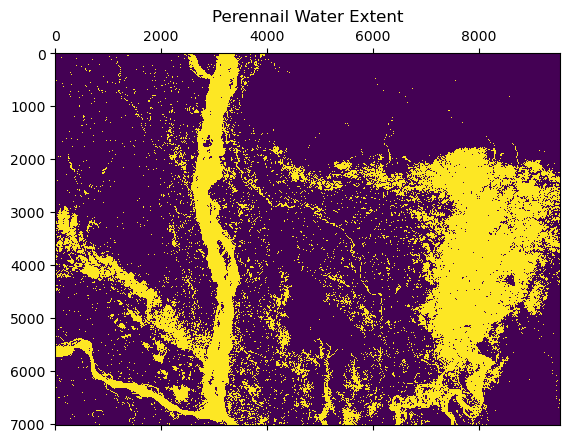

In [12]:
#Get known Water Mask
%matplotlib inline
known_water_mask=get_waterbody(reprojected_flood_mask,'auto', mask)
if show_plots:
    pl.matshow(known_water_mask);pl.title('Perennail Water Extent')

In [13]:
#save permanent water later
gT = gis.getGeoTransform(f"{tiff_dir}/clip_{filename}")
outfilename = tiff_path.split(tiff_dir)[1].split("/")[1]
srs_proj4=gdal_get_projection(f"{tiff_dir}/clip_{filename}")
gis.writeTiff(known_water_mask, gT, filename="_".join(filter(None, [output_prefix,"Perennial_Water",estimator,version,outfilename])), srs_proj4=srs_proj4, options = ["TILED=YES","COMPRESS=LZW","INTERLEAVE=BAND","BIGTIFF=YES"])


File written to: Perennial_Water_iterative-basinhopping_0.1.12_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM.tif


## Grabbing Surface Water Extent Map Created in Lab 2

<font face="Calibri" size="3">Now we grab the Surface Water Extent Map that we created in Lab 2. </font>

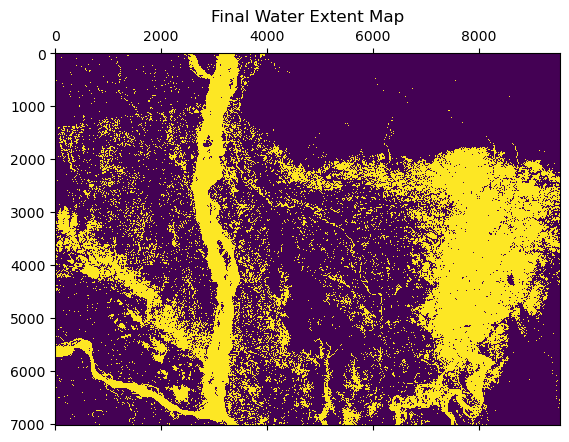

In [14]:
#load and display change detection product from Hyp3
hyp_map = gdal.Open(reprojected_flood_mask)
change_map = hyp_map.ReadAsArray()

#Initial mask layer generation
for c in water_classes: # This allows more than a single water_class to be included in flood mask
    change_map[change_map==c]=1

mask=change_map==1
flood_mask=np.bitwise_or(mask,known_water_mask) #add known water mask... #Added 20200921

if show_plots:
    pl.matshow(flood_mask);pl.title('Final Water Extent Map')

## Flood Depth Map Calculation

<font face="Calibri" size="3"> Now we <b>add known water information to the SAR-derived surface water detection maps</b> and then we <b>generate our desired Flood Depth Product:</b> </font>

Detected 146619 water bodies...
Using estimator: iterative-basinhopping


  0%|          | 0/146618 [00:00<?, ?it/s]

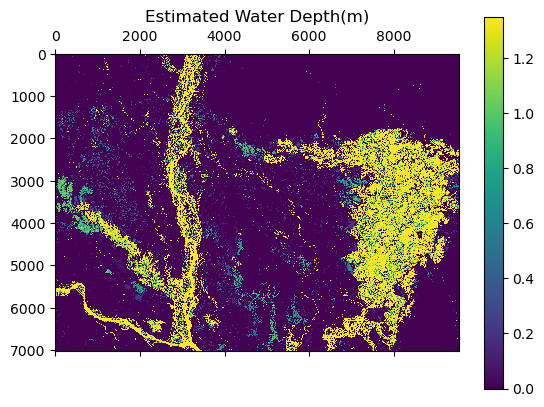

In [15]:
# Calculate Flood Depth - Show Progress Bar
flood_mask_labels, num_labels=ndimage.label(flood_mask)
print(f'Detected {num_labels} water bodies...')
object_slices=ndimage.find_objects(flood_mask_labels)
#if show_plots:
#    pl.matshow(flood_mask_labels);pl.colorbar();

flood_depth=np.zeros(flood_mask.shape)
print(f'Using estimator: {estimator}')
for l in tqdm(range(1,num_labels)):#Skip first, largest label.
    slices=object_slices[l-1] #osl label=1 is in object_slices[0]
    min0=slices[0].start
    max0=slices[0].stop
    min1=slices[1].start
    max1=slices[1].stop
    flood_mask_labels_clip=flood_mask_labels[min0:max0, min1:max1] 

    flood_mask_clip=flood_mask[min0:max0, min1:max1].copy()
    flood_mask_clip[flood_mask_labels_clip!=l]=0 #Maskout other flooded areas (labels)
    hand_clip=hand_array[min0:max0, min1:max1] 
    if estimator.lower() == "numpy":
        m=np.nanmean(hand_clip[flood_mask_labels_clip==l])
        s=np.nanstd( hand_clip[flood_mask_labels_clip==l])
        water_height=m+water_level_sigma*s
    elif estimator.lower() == "nmad":
        m=np.nanmean(hand_clip[flood_mask_labels_clip==l])
        s=stats.median_abs_deviation(hand_clip[flood_mask_labels_clip==l], scale='normal', nan_policy='omit')
        water_height=m+water_level_sigma*s
    elif estimator.lower() == "logstat":
        m=logstat(hand_clip[flood_mask_labels_clip==l], func=np.nanmean)
        s=logstat(hand_clip[flood_mask_labels_clip==l])  
        water_height=m+water_level_sigma*s
    elif "iterative-" in estimator.lower() and  estimator.split('-')[1] !="ensemble":
        #m=np.nanmean(hand_clip[flood_mask_labels_clip==l])
        #s=stats.median_abs_deviation(hand_clip[flood_mask_labels_clip==l], scale='normal', nan_policy='omit')
        #m=logstat(hand_clip[flood_mask_labels_clip==l], func=np.nanmean)
        #s=logstat(hand_clip[flood_mask_labels_clip==l])  
        
        if (flood_mask_labels_clip==l).sum() < 100: #<<< THIS IS NEW 20220726. WE AVOID FILLING IN SMALL AREAS. This helps with getting very large depths in small areas but takes time. 
            water_height = np.nan
        else:
            m=np.nanmean(hand_clip[flood_mask_labels_clip==l])
            s=np.nanstd( hand_clip[flood_mask_labels_clip==l])

            water_height_init=m+water_level_sigma*s  
            if water_height_init >= max(iterative_bounds):
                water_height_init=np.mean(iterative_bounds)
            elif water_height_init <= min(iterative_bounds):
                water_height_init =np.mean(iterative_bounds)
            water_height=iterative(hand_clip, flood_mask_labels_clip==l, water_height_init, water_levels=iterative_bounds, method=estimator.split('-')[1])        
    #elif estimator.lower() == "iterative-ensemble":
    elif "ensemble-" in estimator.lower():
        water_height, temp_wl =ensemble(hand_clip, flood_mask_labels_clip==l, water_levels=iterative_bounds, method=estimator.split('-')[1])            
    else:
        print("Unknown estimator selected for water height calculation.")
        raise ValueError
    #if np.isnan(m) or np.isnan(s):
    #    set_trace()
    flood_depth_clip=flood_depth[min0:max0, min1:max1]
    flood_depth_clip[flood_mask_labels_clip==l]=water_height-hand_clip[flood_mask_labels_clip==l]    

#remove negative depths:
flood_depth[flood_depth<0]=0

if "iterative-" in estimator.lower() and  np.any(np.isnan(flood_depth)):#estimator.split('-')[1] !="ensemble":
    #fill nan using nearest average depth
    nanmask=np.isnan(flood_depth)
    zeromask=flood_depth==0
    flood_depth_no_zero=flood_depth.copy()
    flood_depth_no_zero[zeromask]=np.nan
    flood_depth_interp=fill_nan(flood_depth_no_zero)
    flood_depth[nanmask]=flood_depth_interp[nanmask]    

if show_plots:
    m=np.nanmean(flood_depth)
    s=np.nanstd(flood_depth)
    clim_min=max([m-2*s,0])
    clim_max=min([m+2*s,5])
    pl.matshow(flood_depth);pl.colorbar();pl.clim([clim_min,clim_max]);pl.title('Estimated Water Depth(m)')
    

# Export Your Flood Depth Map as GeoTIFF

In [16]:
#Saving Estimated FD to geotiff
gT = gis.getGeoTransform(f"{tiff_dir}/clip_{filename}")

outfilename = tiff_path.split(tiff_dir)[1].split("/")[1]
srs_proj4=gdal_get_projection(f"{tiff_dir}/clip_{filename}")
gis.writeTiff(flood_depth, gT, filename="_".join(filter(None,[output_prefix,"HAND_WaterDepth",estimator,version,outfilename])), srs_proj4=srs_proj4, nodata=0, options = ["TILED=YES","COMPRESS=LZW","INTERLEAVE=BAND","BIGTIFF=YES"])
gis.writeTiff(flood_mask, gT, filename="_".join(filter(None, [output_prefix,"Flood_mask",estimator,version,outfilename])), srs_proj4=srs_proj4, options = ["TILED=YES","COMPRESS=LZW","INTERLEAVE=BAND","BIGTIFF=YES"])

flood_mask[known_water_mask]=0
flood_depth[np.bitwise_not(flood_mask)]=0
gis.writeTiff(flood_depth, gT, filename="_".join(filter(None,[output_prefix,"HAND_FloodDepth",estimator,version,outfilename])), nodata=0, srs_proj4=srs_proj4, options = ["TILED=YES","COMPRESS=LZW","INTERLEAVE=BAND","BIGTIFF=YES"])
print('Export complete.')

File written to: HAND_WaterDepth_iterative-basinhopping_0.1.12_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM.tif
File written to: Flood_mask_iterative-basinhopping_0.1.12_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM.tif
File written to: HAND_FloodDepth_iterative-basinhopping_0.1.12_S1A_IW_20200713T120451_DVP_RTC30_G_gpuned_2B9B_WM.tif
Export complete.


# Clean Up Temporary and Intermediate Files

In [ ]:
#clear some intermediate files
try:
    os.remove(reprojected_flood_mask)
except:
    pass
try:
    os.remove(f'{tiff_dir}/clip_{filename}')
except:
    pass
try:
    os.remove(f'{tiff_dir}/reproj_{filenoext}.tif')
except:
    pass
try:
    os.remove(f'{tiff_dir}/surface_water_map_clip.tif')
except:
    pass

# Version Log

<font face="Calibri" size="2" color="gray"> <i> Version 0.1.12 - Batu Osmanoglu, MinJeong Jo
    
<b>Change Log</b> <br>
2022/08/01:<br>
- Changed the default value of the stepsize option in optimize.basinhopping(). stepsize=3
- Added 'Auto' threshold implementation to get_waterbody(). This method determines the threshold adaptively to get perennial water layer based on the given flood extent map and surface water map.<br>
2021/01/24:<br>
- Added `iterative` estimator. This method is based on `scipy.optimize.basinhopping` with bounds, which can be specified with the `iterative_bounds` parameter. It takes considerably longer to use iterative method as it tried to match the observed flood-extent pattern at different water levels.<br> 
2021/01/19:<br>
- Minor cleanup and threshold implementation to `get_waterbody`. Also changed the dataset to 2019 (`downloads2019v2`). <br> 
2020/12/01:<br>
- Added new statistical estimators for maximum water height: numpy, nmad or logstat. Numpy uses standard mean, and std.dev. functions. NMAD uses normalized mean absolute difference for sigma. See `scipy.stats.median_abs_deviation()` for details. logstat uses standard mean and std.dev functions after taking the logarithm of the data. See `logstat()` for details. <br>
2020/11/09: <br>
-Changed known water source, Occurrence 2019 vertion. Added a threshold variable. <br>
2020/10/22: <br>
-BugFix: During reproj EPSG code was wrongly identified. Also if EPSG code is read-wrong the -s_srs flag in gdal_warp causing the reprojection to fail. Fixed both. <br>
-Testing: Replaced standard deviation with normalized mean absolute deviation. For large riverine floods, large water objects result in overestimation of sigma resulting in deeper than expected water depths.  <br>
-Feat: Removing negative water depths in the final map. <br>
2020/10/10: <br>
-BugFix: Looks like with the recent updates `gdal.Info(tiff_path, options = ['-json'])` returns a dict instead of a string. Fixed the collection of projection based on this. <br>
-Feat: Allowing to continue even if HAND is smaller than image. This is useful if SAR image covers significant amount of ocean etc. <br>
-BugFix: gis.readData() was failing to read the VRT generated in get_waterbody. gdalwarp outputs a GeoTif now. <br>
2020/10/01: <br>
- Feat: Moving away from repetitive argwhere to ndimage.find_objects results in ~6000x faster calculation.
2020/09/30: <br>
- BugFix: The known water mask and input mask was merged using a sum operator instead of a bitwise_or operator.<br> 
2020/09/20:<br>
- BugFix: Added known water download and addition to the mask. This helps to make sure known water bodies are handled as a single object. Removed morphological filters also. <br>
2020/09/17:<br>
- First version. 
</i></font>